__собираем статистики по объявлениям о продаже домов__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Вт 16 июл 2024 13:28:33 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# df = pd.read_pickle('data/2024/df_house.pkl')
# df['dt'] = df['ts'].dt.date
# display( len(df) )
# cols = ['title','address','latitude','longitude','priceM','dt']
# display( df.sample(3)[cols] )

In [4]:
df = pd.read_pickle('data/2023/data_house.pkl').rename(columns={'adr':'address'})
df['dt'] = df['ts'].dt.date
cols = ['title','address','latitude','longitude','priceM','dt']
display( len(df) )
display( df.sample(3)[cols] )

24429

,title,address,latitude,longitude,priceM,dt
21936,дом 261 м² на участке 10 сот.,"Бахчисарай,с. Брянское, ул. Гаспринского, 29",44.862672,33.796139,2.30,2024-06-04
4299,дом 300 м² на участке 5 сот.,"Севастополь,Наваринская ул., 12",44.605522,33.514697,57.00,2022-09-16
11513,"дом 45,1 м² на участке 5,2 сот.","Севастополь,садоводческое товарищество Ветеран, 2-я Персиковая ул., 84",44.571127,33.500378,6.25,2022-11-07


In [5]:
# df_ = (
#         df_
#         .dropna(subset=['dt','url'])
#         .drop_duplicates(['dt','url'])
#         .drop(columns=['adr_orig','obj_name','avito_page'])
#     )
# display( len(df_) )
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# display( df_.sample(3)[cols] )

In [6]:
# # history_date = df_['dt'].max()
# history_date = pd.to_datetime('2023-01-10').date()
# display(history_date)

In [7]:
# df = pd.concat([df,df_]).reset_index(drop=True)
# display( len(df) )
# del df_

---

In [8]:
df['month'] = df['ts'].dt.to_period('M')
df['week'] = df['ts'].dt.to_period('W')

---

In [9]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

24429

24400

In [10]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_part) & (house_area>40.) & (priceM<15.)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

24400

17126

17095

In [11]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt
4170,дом 104 м² на участке 5 сот.,"Севастополь,ул. Генерала Мельника, 102А",44.582588,33.555813,6.10,2022-09-16
18694,"дом 70 м² на участке 5,6 сот.","Севастополь,СНТСН Солнечный",44.569078,33.590111,8.50,2023-01-10
14507,дом 126 м² на участке 5 сот.,"Севастополь,Фёдоровская ул., 171А",44.680545,33.573294,7.20,2022-11-15


---

In [12]:
gdf = gdf[ gdf['dt']<pd.to_datetime('2024-01-01 00:00:00').date() ] 

In [14]:
dt_max = gdf['dt'].max()
dt_min = gdf['dt'].min()
print( dt_min, ' : ',dt_max )
# display( dt_min,history_date,dt_max )

2022-09-15  :  2023-01-10


In [15]:
gdf = gdf.query('place in ("bahchisaray","sudak","sevastopol")')

In [16]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [17]:
# display( len(gdf_history) )
# display( len(gdf) )

---

In [18]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# gdf[ (gdf['place']=='sevastopol') & (gdf['address'].str.match(r'.*Судак.*')) ][cols]

In [19]:
# gdf['place'].unique()

# общая статистика

In [20]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [21]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [22]:
# gdf[ gdf['address'].str.match(r'.*ялта.*') ]
# gdf[ gdf['address'].str.match(r'.*окуневка.*') ]
# gdf[ gdf['address'].str.match(r'.*заветное.*') ]

In [23]:
gdf.query('place=="bahchisaray"')[['title','address','priceM','geometry']].explore()

In [24]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

In [25]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
        #gdf.groupby(['place','house_size_category','month'],observed=True)
        gdf.groupby(['place','house_size_category','week'],observed=True)
    
        ['priceM'].describe(percentiles=percentiles)
    )

# display( stat )

In [26]:
stat.reset_index()['house_size_category'].unique()

['30-50', '50-70', '70-150', '150-300', '300+']
Categories (5, object): ['30-50' < '50-70' < '70-150' < '150-300' < '300+']

In [27]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
# sizes = stat.reset_index()['house_size_category'].unique()
# sizes = ['50-70', '70-110','110-180', '180-300' ]
sizes = [ '50-70', '70-150', '150-300']
# sizes = ['50-70', '70-150','150-300' ]
display(sizes)

['50-70', '70-150', '150-300']

In [37]:
# (
# gdf
# .query('house_size_category in @sizes')
# .drop_duplicates(['url'])
# .groupby(['house_size_category','place'],observed=True)['url'].count()
# .reset_index()
# .pivot(index='place', columns='house_size_category', values='url')
# .plot.barh(title='количество предложений') #,log=True)
# .grid(axis='x')    
# )

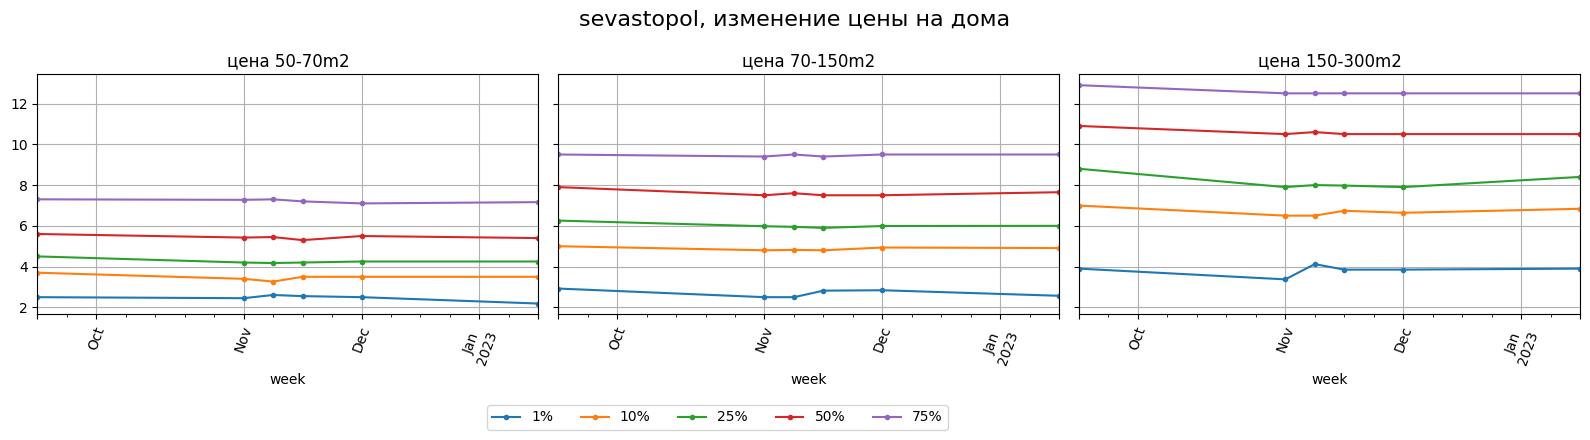

In [30]:
place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

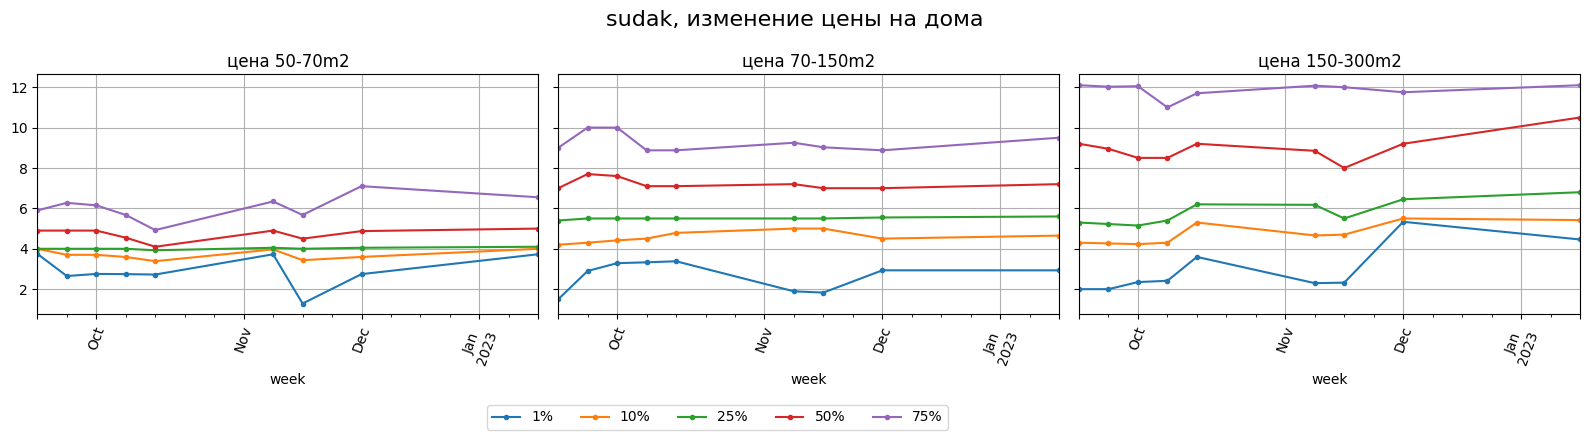

In [31]:
place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()